In [1]:
!wget https://storage.googleapis.com/example-dataset-bucket/example-dataset.zip

--2024-10-20 09:46:08--  https://storage.googleapis.com/example-dataset-bucket/example-dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.207, 64.233.189.207, 108.177.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187806331 (179M) [application/x-zip-compressed]
Saving to: 'example-dataset.zip'

example-dataset.zip 100%[===================>] 179.11M  30.2MB/s    in 7.0s    

2024-10-20 09:46:16 (25.7 MB/s) - 'example-dataset.zip' saved [187806331/187806331]



In [2]:
!unzip /kaggle/working/example-dataset.zip

Archive:  /kaggle/working/example-dataset.zip
   creating: example-dataset/train/
   creating: example-dataset/train/1/
  inflating: example-dataset/train/1/COR_T1.nii  
  inflating: example-dataset/train/1/COR_T1_C.nii  
  inflating: example-dataset/train/1/COR_T2.nii  
  inflating: example-dataset/train/1/mask.nii  
   creating: example-dataset/train/10/
  inflating: example-dataset/train/10/COR_T1.nii  
  inflating: example-dataset/train/10/COR_T1_C.nii  
  inflating: example-dataset/train/10/COR_T2.nii  
  inflating: example-dataset/train/10/mask.nii  
   creating: example-dataset/train/11/
  inflating: example-dataset/train/11/COR_T1.nii  
  inflating: example-dataset/train/11/COR_T1_C.nii  
  inflating: example-dataset/train/11/COR_T2.nii  
  inflating: example-dataset/train/11/mask.nii  
   creating: example-dataset/train/2/
  inflating: example-dataset/train/2/COR_T1.nii  
  inflating: example-dataset/train/2/COR_T1_C.nii  
  inflating: example-dataset/train/2/COR_T2.nii  
  in

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.4 MB/s eta 0:00:00:00:0100:01


In [4]:
import numpy as np

import pandas as pd



import random

from glob import glob

import os, shutil

from tqdm import tqdm

tqdm.pandas()

import time

import copy

import joblib

from collections import defaultdict

import gc

from IPython import display as ipd



# visualization

from PIL import Image

import cv2

import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle



# Sklearn

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold



# PyTorch 

import torch

import torch.nn as nn

import torch.optim as optim

from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader

from torch.cuda import amp



import timm



# Albumentations for augmentations

import albumentations as A

from albumentations.pytorch import ToTensorV2



import rasterio

from joblib import Parallel, delayed



# For colored terminal text

from colorama import Fore, Back, Style

c_  = Fore.GREEN

sr_ = Style.RESET_ALL



import warnings

warnings.filterwarnings("ignore")



# For descriptive error messages

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"



import pydicom as dicom

import nibabel as nib

import sys

import glob

import os

import numpy as np

import h5py

from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
import pydicom as dicom

import nibabel as nib

import sys

import glob

import os

import numpy as np

import h5py

from sklearn.preprocessing import StandardScaler

# Данные




## Для скачивания 13 семплов из открытых источников 

In [6]:
def read_nii(filepath):

    '''

    Reads .nii file and returns pixel array

    '''

    ct_scan = nib.load(filepath)

    array   = ct_scan.get_fdata()

    array   = np.rot90(np.array(array),3)

    return(array)

In [7]:
img_dir = r'/kaggle/working/example-dataset' 

dataset_X = []

dataset_y = []

for split in ['train','val']:

        files = glob.glob(os.path.join(img_dir, split, '**'))

        negative_samples = []

        for i, subject in enumerate(files):

            print('{}/{} {}'.format(i+1,len(files),subject))

            mask = os.path.join(subject, 'mask.nii')

            cor_t1_c = os.path.join(subject, 'COR_T1_C.nii')

            # cor_t1 = os.path.join(subject, 'COR_T1.nii')

            cor_t2 = os.path.join(subject, 'COR_T2.nii')



            sample_t1_c = read_nii(cor_t1_c)

            # sample_t1 = read_nii(cor_t1)

            sample_t2 = read_nii(cor_t2)

            sample_mask  = read_nii(mask)



            for i in range(sample_mask.shape[-1]):

                for j in [ sample_t1_c,sample_t2]:

                    if (sum(sum(sample_mask[...,i])))>0:

                            mask = sample_mask[...,i]

                            mask[mask==3] = 0

                            mask[mask==2] = 0

                            dataset_X.append(j[...,i])

                            dataset_y.append(sample_mask[...,i])






1/11 /kaggle/working/example-dataset/train/7
2/11 /kaggle/working/example-dataset/train/1
3/11 /kaggle/working/example-dataset/train/9
4/11 /kaggle/working/example-dataset/train/11
5/11 /kaggle/working/example-dataset/train/2
6/11 /kaggle/working/example-dataset/train/4
7/11 /kaggle/working/example-dataset/train/3
8/11 /kaggle/working/example-dataset/train/10
9/11 /kaggle/working/example-dataset/train/8
10/11 /kaggle/working/example-dataset/train/5
11/11 /kaggle/working/example-dataset/train/6
1/3 /kaggle/working/example-dataset/val/14
2/3 /kaggle/working/example-dataset/val/13
3/3 /kaggle/working/example-dataset/val/12


## Для преобразования меток и масок сегментации


In [8]:
def read_labels_from_file(file_path):

    values = []

    with open(file_path, 'r', encoding='utf-8') as f:

        lines = f.readlines()

        for line in lines:

            try:

                value = int(line.split(': ')[1])

            except ValueError:

                value = line.split(': ')[1].strip()  # Если значение не может быть преобразовано в int, оставляем его как строку

            if str(value) in ['3а'  ,'3','3a']:

                value = '3a'

            values.append(value)

    return values

In [9]:
file_path = os.path.join('/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_101/ID101', 'labels.txt')



values = read_labels_from_file('/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_101/labels.txt')

print(values)

[0, 2]


In [10]:
def load_tif(x_path, y_path,count_dict, step=4): #преобразует tif в массив масок и снимков

    images = []

    masks = []

    mean = []

    image = Image.open(x_path)

    mask = Image.open(y_path)

    i = 0

    cnt = 0

    

    while True:

        try:

            mask.seek(i)

            mask_array = np.array(mask)

            image.seek(i)

            image_array = np.array(image)

            mean.append(sum(sum(mask_array)))

            if sum(sum(mask_array)) > 0: #Проверка, что маска не полностью черная

                    masks.append(mask_array)

                    images.append(image_array)

            cnt+=1

                    

            i += 1

        except EOFError:

            break



    if 'T1' in x_path:

        count_dict['scan'].append('T1')

    elif 'T2' in x_path:

        count_dict['scan'].append('T2')     

    count_dict['count'].append(cnt)

    

    return images, masks

In [11]:
def get_images(x_pathes, y_pathes):



    images =[]

    masks = []

    count_dict = {'scan':[],'count':[],}

    for x_path, y_path in zip(x_pathes, y_pathes):

          

          images_sample,mask_sample = load_tif(x_path, y_path,count_dict)

          for im,ms in zip(images_sample,mask_sample):

                

                images.append(im)

                masks.append(ms)

            #     fig , ax =  plt.subplots( 1,2, figsize=(18, 18))

            #     # for i in range(len(ms[7:14])):

            #     # ax[i][0].imshow(im[i])

            #     # ax[i][1].imshow(ms[i])

            #     ax[0].imshow(im)

            #     ax[1].imshow(im)

            #     ax[1].imshow(ms, alpha=0.5)

            #     plt.show()

    print(len(count_dict['count']))

    return images, masks ,count_dict

In [12]:
def get_images_mean(x_pathes, y_pathes):



    images =[]

    masks = []

    count_dict = {'scan':[],'count':[],}

    for x_path, y_path in zip(x_pathes, y_pathes):

          

          images_sample,mask_sample = load_tif(x_path, y_path,count_dict)

          for im,ms in zip(images_sample,mask_sample):

                

                images.append(im)

                masks.append(ms)

            #     fig , ax =  plt.subplots( 1,2, figsize=(18, 18))

            #     # for i in range(len(ms[7:14])):

            #     # ax[i][0].imshow(im[i])

            #     # ax[i][1].imshow(ms[i])

            #     ax[0].imshow(im)

            #     ax[1].imshow(im)

            #     ax[1].imshow(ms, alpha=0.5)

            #     plt.show()

    print(len(count_dict['count']))

    return images, masks ,count_dict

In [13]:
def get_pathes(path): #обходит директорию и сохранятет пути пациентов 

    x_pathes_all = []

    y_pathes_all = []

    for patient in os.listdir(path):

        x_pathes = []

        y_pathes = []

      

        for ID_s in os.listdir(path + '/'+ patient ):

            if 'ID' in ID_s:

                msk_t1 = 0

                msk_t2 = 0  

                for tif_name in os.listdir(path + '/'+ patient + '/'+ID_s):

    

                    if 'Cor' in tif_name:

                        if 'T1' in tif_name:

            

                            if  'mask' not in tif_name.lower():

                                x_pathes.append(path + '/'+ patient + '/' + ID_s + '/'+ tif_name)



                            elif 'mask' in tif_name.lower():

                                msk_t1 = 1

                                y_pathes.append(path + '/'+ patient + '/'+ID_s + '/' + tif_name)



                        elif 'T2' in tif_name:

                            

                            if 'mask' not in tif_name.lower():

                                x_pathes.append(path + '/'+ patient + '/'+ID_s + '/' + tif_name)

                              

                            elif 'mask' in tif_name.lower():

                                msk_t2 = 1

                                y_pathes.append(path + '/'+ patient + '/'+ID_s + '/' + tif_name)

                        

                if msk_t1==0:

                    x_pathes.pop()

                if msk_t2==0:

                    x_pathes.pop()

                        

        x_pathes_all.append(x_pathes)

        y_pathes_all.append(y_pathes)

                

                

    return x_pathes_all, y_pathes_all


In [14]:
def flatten(xss): # для развертки и однородности списков 

    return [x for xs in xss for x in xs]

In [35]:
x_pth ,y_pth = get_pathes('/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72')

In [36]:
x_pth

[[],
 ['/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_298/ID298/ID298_Cor T2 FRFSE 2mm_SE6.tif',
  '/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_298/ID298/ID298_Cor T1 FSE+C_SE8.tif'],
 ['/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_112/ID112/ID112_Cor T2 FRFSE 2mm_SE7.tif',
  '/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_112/ID112/ID112_Cor T1 FSE+C_SE10.tif'],
 ['/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_346/ID346/ID346_Cor T2 FSE (Thin)_SE8.tif',
  '/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_346/ID346/ID346_ Cor T1 SE+C_SE12.tif'],
 ['/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_2/ID 2/ID2_Cor T2_SE3.tif',
  '/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_2/ID 2/ID2_Cor T1+C_SE8.tif'],
 ['/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_64/ID64/ID64_Cor T2 FRFSE 2mm_SE7.tif',
  '/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_64/ID64/ID64_C

In [28]:
x_pth ,y_pth = [flatten(i) for i in [x_pth ,y_pth]]

In [124]:
im,ms,cnt= get_images(x_pth ,y_pth)

AttributeError: 'list' object has no attribute 'read'

## Визуализация статистики по маскам


In [35]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

In [37]:
image_count_all= pd.DataFrame(cnt)

image_count_all

,scan,count
0,T2,10
1,T1,10
2,T2,15
3,T1,12
4,T2,11
...,...,...
503,T2,14
504,T2,10
505,T1,10
506,T1,20


<Axes: xlabel='count', ylabel='Density'>

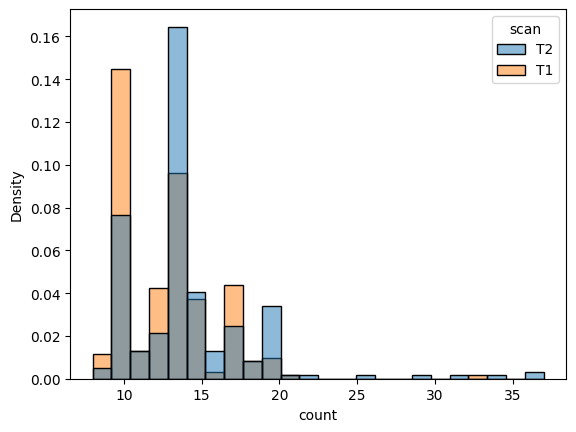

In [39]:
# image_count_all= pd.DataFrame(cnt,columns=['type','count'])

sns.histplot(data = image_count_all,x='count',hue='scan', stat="density")

<Axes: xlabel='count', ylabel='Density'>

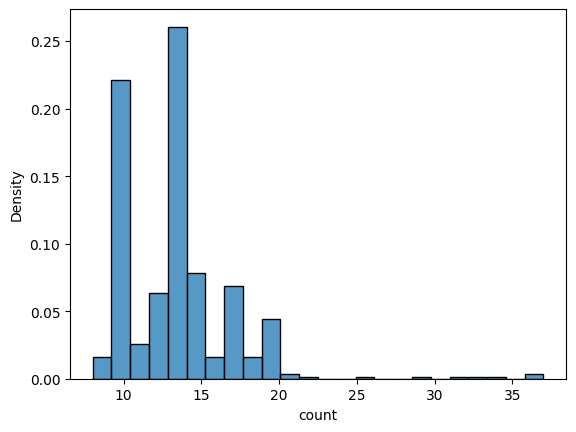

In [41]:
# image_count_all= pd.DataFrame(cnt,columns=['image_count_all'])

sns.histplot(data = image_count_all,x='count', stat="density")

In [42]:
len(im)

3112

In [43]:
len(ms)

3112

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_pth ,y_pth = [flatten(i) for i in [x_pth ,y_pth]]

In [37]:
x_pth_train,x_pth_val,y_pth_train,y_pth_val = train_test_split(x_pth , y_pth, test_size=0.14)



print(x_pth_train)

x_pth_train,y_pth_train,x_pth_val,y_pth_val = flatten(x_pth_train) ,flatten(y_pth_train),flatten(x_pth_val),flatten(y_pth_val)

[['/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_118/ID118/ID118_Cor T1 FSE+C_SE11.tif', '/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_118/ID118/ID118_Cor T2 FRFSE 2mm_SE7.tif'], ['/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_147/ID147/ID147_Cor T2 FRFSE 2mm_SE9.tif', '/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_147/ID147/ID147_Cor T1 FSE+C_SE13.tif'], ['/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_218/ID218/ID218_Cor T1 FSE+C_SE12.tif', '/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_218/ID218/ID218_Cor T2 FRFSE 2mm_SE5.tif'], ['/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_308/ID308/ID308_Cor T2 FSE (Thin)_SE4.tif', '/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_308/ID308/ID308_ Cor T1 SE+C_SE6.tif'], ['/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_169/ID169/ID169_ Cor T1 SE+C_SE10.tif', '/kaggle/input/brain-tumor-mri/data_29_05_24_cls108_seg72/ID_169/ID16

In [38]:
len(y_pth_val)

68

In [39]:
x_val,y_val,_ = get_images(x_pth_val ,y_pth_val) 

x_train,y_train,_= get_images(x_pth_train ,y_pth_train)

68
440


In [34]:
len(x_train)

NameError: name 'x_train' is not defined

In [128]:
len(x_val)

433

## Датасет

In [40]:
class BuildDataset(torch.utils.data.Dataset): # загружает в оперативную память так как на стенде 128Гб 

    def __init__(self, X,y, label=True, transforms=None):

        self.label      = label

        self.img_paths  = X

        self.msk_paths  = y

        self.transforms = transforms

        

    def __len__(self):

        return len(self.img_paths)

    

    def __getitem__(self, index):

        if self.label == True:

            img = self.img_paths[index]

            msk = self.msk_paths[index]

            if self.transforms:

                data = self.transforms(image=np.array(img/255., dtype=np.float32)  , mask=np.array(msk, dtype=np.float32))

                img  = data['image']

                msk  = data['mask']



            return torch.tensor([img]), torch.tensor([msk])

        else:

            img = self.img_paths[index]

            if self.transforms:

                data = self.transforms(image=np.array(img/255., dtype=np.float32))

                img  = data['image']

            return torch.tensor([img])

In [41]:
data_transforms = {

    "train": A.Compose([

        A.augmentations.crops.transforms.CenterCrop(224,224),

        A.Resize(224,224, interpolation=cv2.INTER_NEAREST),

        A.HorizontalFlip(p=0.5),

        A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=1.),

        A.OneOf([

            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),

# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),

            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=None, p=1.0)

        ], p=0.25),

        A.CoarseDropout(max_holes=8, max_height=224//20, max_width=224//20,

                         min_holes=5, fill_value=0, mask_fill_value=0, p=1.0),

        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),

        ]

        , p=1.0),

    

    "valid": A.Compose([

        A.augmentations.crops.transforms.CenterCrop(224,224),

        A.Resize(224,224, interpolation=cv2.INTER_NEAREST),

        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),

        ], p=1.0)

}

In [42]:
train_dataset = BuildDataset( np.concatenate((dataset_X, x_train), axis=0),np.concatenate((dataset_y, y_train), axis=0), transforms=data_transforms['valid'])

# train_dataset = BuildDataset(  x_train, y_train, transforms=None)

valid_dataset = BuildDataset(x_val,y_val, transforms=data_transforms['valid'])



train_loader = DataLoader(train_dataset, batch_size=5,shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)


In [43]:
def plot_batch(imgs, msks, size=3):

    plt.figure(figsize=(5*5, 5))

    for idx in range(size):

        plt.subplot(1, size, idx+1)

        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0

 

        msk = msks[idx,].permute((1, 2, 0)).numpy()

        show_img(img, msk)

    plt.tight_layout()

    plt.show()

In [44]:
def show_img(img, mask=None):



#     img = clahe.apply(img)

#     plt.figure(figsize=(10,10))

    plt.imshow(img, cmap='bone')

    

    

        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')

    plt.imshow(mask, alpha=0.5)

    handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0)]]

    labels = ["Adenoma"]

    plt.legend(handles,labels)

    plt.axis('off')

In [45]:
train_dataset = BuildDataset( np.concatenate((dataset_X, x_train), axis=0),np.concatenate((dataset_y, y_train), axis=0), transforms=None)

valid_dataset = BuildDataset(x_val,y_val, transforms=data_transforms['valid'])



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [74]:
len(np.concatenate((dataset_X, x_train)))

2759

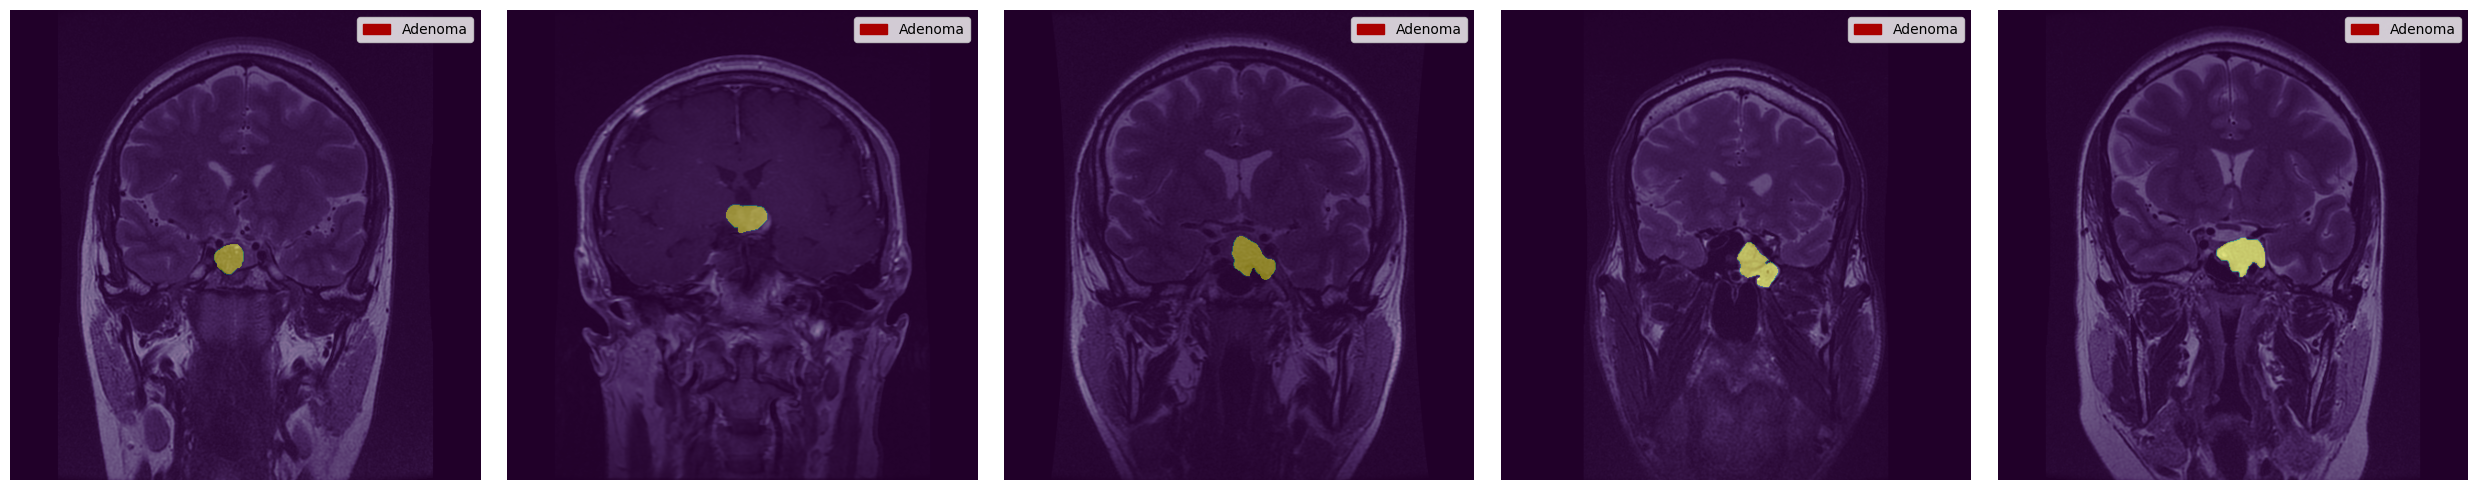

In [134]:
imgs, msks = next(iter(train_loader))

imgs.size(), msks.size()

plot_batch(imgs, msks, size=5)

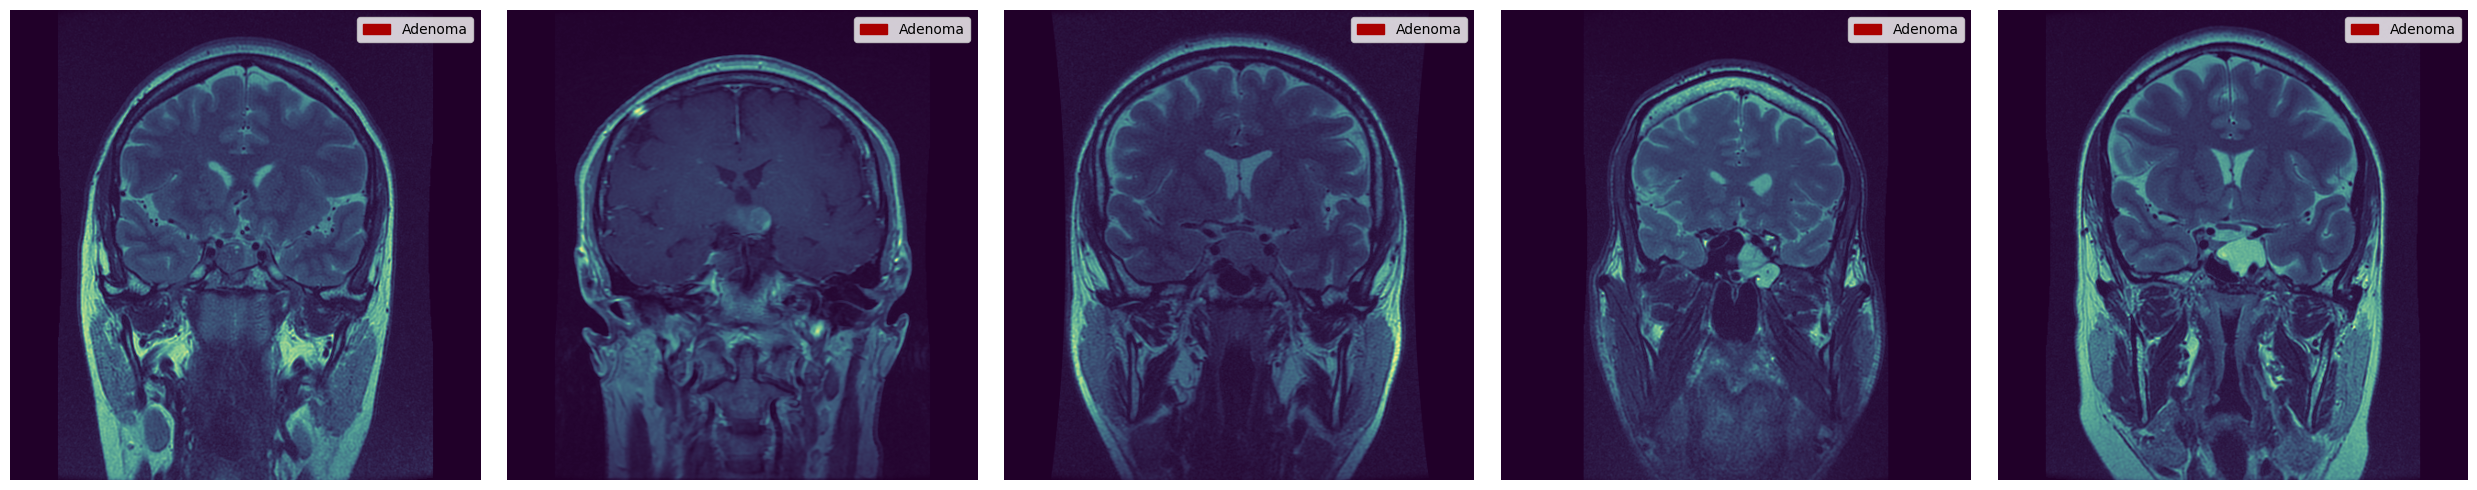

In [135]:
plot_batch(imgs, imgs, size=5)

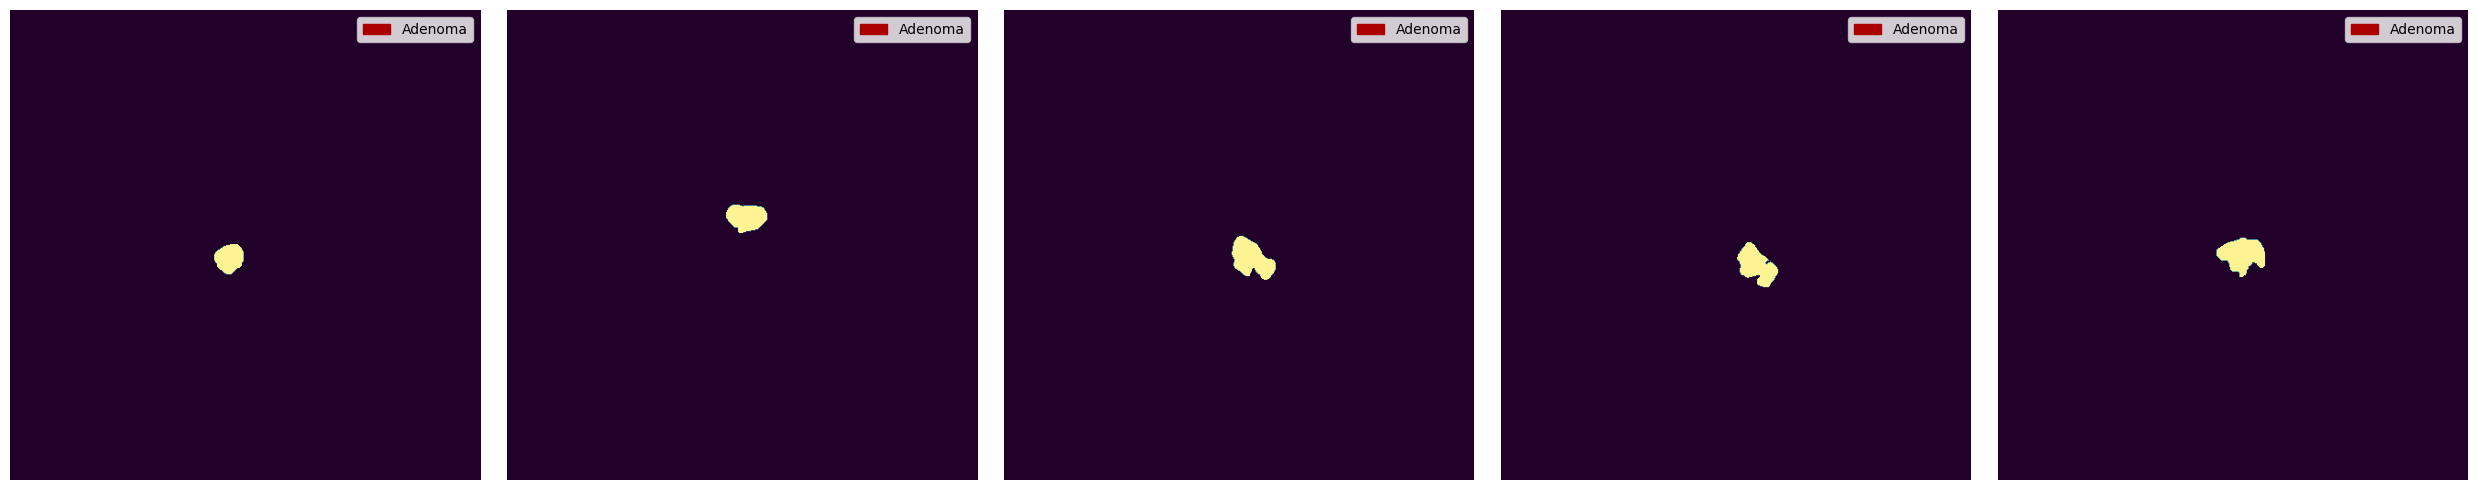

In [136]:
plot_batch(msks, msks, size=5)

# Модель и обучение

In [46]:
import gc

gc.collect()

932

## Архитектура 

In [47]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=a14e164d4a36a105ccd0fc57457858f4749a3fafeffcfe7a56e4e50c8de41bc3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=bd37b8cf03aa152b2fca230925f5f3f1a0265fd9dc13362be9055e387d59c0d1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [48]:
import segmentation_models_pytorch as smp



def build_model():

    model = smp.UnetPlusPlus(

        encoder_name='efficientnet-b1' ,     # choose encoder, e.g. mobilenet_v2 or efficientnet-b7

        encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization

        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)

        classes=1   ,     # model output channels (number of classes in your dataset)

        activation=None,

    )

    model.to('cuda')

    return model



def load_model(path):

    model = build_model()

    model.load_state_dict(torch.load(path))

    model.eval()

    return model

## Loss

In [49]:
JaccardLoss = smp.losses.JaccardLoss(mode='binary')

DiceLoss    = smp.losses.DiceLoss(mode='binary')

BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

LovaszLoss  = smp.losses.LovaszLoss(mode='binary', per_image=False)

TverskyLoss = smp.losses.TverskyLoss(mode='binary', log_loss=False)



def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):

    y_true = y_true.to(torch.float32)

    y_pred = (y_pred>thr).to(torch.float32)

    inter = (y_true*y_pred).sum(dim=dim)

    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)

    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))

    return dice



def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):

    y_true = y_true.to(torch.float32)

    y_pred = (y_pred>thr).to(torch.float32)

    inter = (y_true*y_pred).sum(dim=dim)

    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)

    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))

    return iou



def criterion(y_pred, y_true):

    return BCELoss(y_pred, y_true) +TverskyLoss(y_pred, y_true) 

    # return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

## Цикл обучения


In [50]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):

    model.train()

    scaler = amp.GradScaler()

    train_scores = []

    dataset_size = 0

    running_loss = 0.0

    

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')

    for step, (images, masks) in pbar:         

        images = images.to(device, dtype=torch.float)

        masks  = masks.to(device, dtype=torch.float)

        

        batch_size = images.size(0)

        

        with amp.autocast(enabled=True):

            y_pred = model(images)

            

            loss   = criterion(y_pred, masks)

            loss   = loss / CFG.n_accumulate

            

        scaler.scale(loss).backward()

    

        if (step + 1) % CFG.n_accumulate == 0:

            scaler.step(optimizer)

            scaler.update()



            # zero the parameter gradients

            optimizer.zero_grad()



            if scheduler is not None:

                scheduler.step()

                

        running_loss += (loss.item() * batch_size)

        dataset_size += batch_size

        

        epoch_loss = running_loss / dataset_size



        y_pred = (nn.Sigmoid()(y_pred)).double()

        train_dice = dice_coef(masks, y_pred).cpu().detach().numpy()

        vtrain_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()

        train_scores.append([train_dice, vtrain_jaccard])

        

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

        current_lr = optimizer.param_groups[0]['lr']

        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',

                        lr=f'{current_lr:0.5f}',

                        gpu_mem=f'{mem:0.2f} GB')

        

    train_scores  = np.mean(train_scores, axis=0)    

    torch.cuda.empty_cache()

    gc.collect()

    

    return epoch_loss,train_scores

In [51]:
@torch.no_grad()

def valid_one_epoch(model, dataloader, device, epoch):

    model.eval()

    

    dataset_size = 0

    running_loss = 0.0

    

    val_scores = []

    

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')

    for step, (images, masks) in pbar:        

        images  = images.to(device, dtype=torch.float)

        masks   = masks.to(device, dtype=torch.float)

        

        batch_size = images.size(0)

        

        y_pred  = model(images)

        loss    = criterion(y_pred, masks)

        

        running_loss += (loss.item() * batch_size)

        dataset_size += batch_size

        

        epoch_loss = running_loss / dataset_size

        

        y_pred = (nn.Sigmoid()(y_pred)).double()

        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()

        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()

        val_scores.append([val_dice, val_jaccard])

        

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

        current_lr = optimizer.param_groups[0]['lr']

        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',

                        lr=f'{current_lr:0.5f}',

                        gpu_memory=f'{mem:0.2f} GB')

        

        

    val_scores  = np.mean(val_scores, axis=0)

    torch.cuda.empty_cache()

    gc.collect()

    

    return epoch_loss, val_scores

In [52]:
time.time()

1729418213.2133064

In [53]:
def run_training(model, optimizer, scheduler, device, num_epochs):

    # To automatically log gradients

    # wandb.watch(model, log_freq=100)

    

    if torch.cuda.is_available():

        print("cuda: {}\n".format(torch.cuda.get_device_name()))

    

    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())

    best_dice      = -np.inf

    best_epoch     = -1

    history = defaultdict(list)

    

    for epoch in range(1, num_epochs + 1): 

        gc.collect()

        print(f'Epoch {epoch}/{num_epochs}', end='')

        train_loss,train_scores = train_one_epoch(model, optimizer, scheduler, 

                                           dataloader=train_loader, 

                                           device=CFG.device, epoch=epoch)

        train_dice,train_jaccard = train_scores



        print(f'Train Dice: {train_dice:0.4f} | Train Jaccard: {train_jaccard:0.4f}')



        val_loss, val_scores = valid_one_epoch(model, valid_loader, 

                                                 device=CFG.device, 

                                                 epoch=epoch)

        val_dice, val_jaccard = val_scores

    

        history['Train Loss'].append(train_loss)

        history['Train Dice'].append(train_dice)

        history['Train Jaccard'].append(train_jaccard)

        history['Valid Loss'].append(val_loss)

        history['Valid Dice'].append(val_dice)

        history['Valid Jaccard'].append(val_jaccard)

        

        # Log the metrics

        # wandb.log({"Train Loss": train_loss, 

        #            "Valid Loss": val_loss,

        #            "Valid Dice": val_dice,

        #            "Valid Jaccard": val_jaccard,

        #            "LR":scheduler.get_last_lr()[0]})

        

        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')

        

        # deep copy the model

        if val_dice > best_dice:

            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")

            best_dice    = val_dice

            best_jaccard = val_jaccard

            best_epoch   = epoch

            run.summary["Best Dice"]    = best_dice

            run.summary["Best Jaccard"] = best_jaccard

            run.summary["Best Epoch"]   = best_epoch

            best_model_wts = copy.deepcopy(model.state_dict())

            PATH = f"best_epoch-{fold:02d}.bin"

            torch.save(model.state_dict(), PATH)

            # Save a model file from the current directory

            # wandb.save(PATH)

            print(f"Model Saved{sr_}")

            

        last_model_wts = copy.deepcopy(model.state_dict())

        PATH = f"last_epoch-{fold:02d}.bin"

        torch.save(model.state_dict(), PATH)

            

        print(); print()

    

    end = time.time()

    time_elapsed = end - start

    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(

        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))

    print("Best Score: {:.4f}".format(best_jaccard))

    

    # load best model weights

    model.load_state_dict(best_model_wts)

    

    return model, history

In [54]:
class CFG:

    seed          = 42

    debug         = False # set debug=False for Full Training

    exp_name      = 'Baselinev2'

    comment       = 'unet-efficientnet_b1-224x224-aug2-split2'

    model_name    = 'Unet'

    backbone      = 'efficientnet-b1'

    train_bs      = 128

    valid_bs      = train_bs*2

    img_size      = [224, 224]

    epochs        = 200

    lr            = 1e-4

    scheduler     = 'CosineAnnealingLR'

    min_lr        = 1e-6

    T_max         = int(30000/train_bs*epochs)+50

    T_0           = 25

    warmup_epochs = 0

    wd            = 1e-6

    n_accumulate  = max(1, 32//train_bs)

    n_fold        = 5

    num_classes   = 3

    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
def fetch_scheduler(optimizer):

    if CFG.scheduler == 'CosineAnnealingLR':

        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 

                                                   eta_min=CFG.min_lr)

    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':

        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 

                                                             eta_min=CFG.min_lr)

    elif CFG.scheduler == 'ReduceLROnPlateau':

        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,

                                                   mode='min',

                                                   factor=0.1,

                                                   patience=7,

                                                   threshold=0.0001,

                                                   min_lr=CFG.min_lr,)

    elif CFG.scheduer == 'ExponentialLR':

        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

    elif CFG.scheduler == None:

        return None

        

    return scheduler

In [57]:
model = build_model()

optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

scheduler = fetch_scheduler(optimizer)

In [58]:
import wandb



try:

    from kaggle_secrets import UserSecretsClient

    user_secrets = UserSecretsClient()

    api_key = user_secrets.get_secret("WANDB")

    wandb.login(key=api_key)

    anonymous = None

except:

    anonymous = "must"

    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


In [59]:
data_transforms = {

    "train": A.Compose([

        A.augmentations.crops.transforms.CenterCrop(256,256),

        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),

        A.CoarseDropout(max_holes=8, max_height=256//20, max_width=256//20,

                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),

        



        A.HorizontalFlip(p=0.5),

#         A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),

        A.OneOf([

            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),

            # A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),

            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=None, p=1.0)

        ], p=0.25),

        # A.ColorJitter(brightness=0, contrast=0.0002, saturation=0, hue=0.2, always_apply=False, p=0.5),

        # A.CoarseDropout(max_holes=8, max_height=224//20, max_width=224//20,

        #                  min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),

        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),

        ], p=1.0),

    

    "valid": A.Compose([

        A.augmentations.crops.transforms.CenterCrop(256,256),

        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),

        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),

        ], p=1.0)

}

train_dataset = BuildDataset(np.concatenate((dataset_X, x_train), axis=0),np.concatenate((dataset_y, y_train), axis=0), transforms=data_transforms['train'])

valid_dataset = BuildDataset(x_val,y_val, transforms=data_transforms['valid'])



train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
# train_dataset = BuildDataset(dataset_X,dataset_y, transforms=data_transforms['train'])

# valid_dataset = BuildDataset(dataset_X_v,dataset_y_v, transforms=data_transforms['valid'])



# train_loader = DataLoader(train_dataset, batch_size=16,shuffle=True)

# valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [ ]:
# np.concatenate((dataset_X, x_train), axis=0),np.concatenate((dataset_y, y_train), axis=0)



# train_dataset = BuildDataset(np.concatenate((dataset_X, x_train), axis=0),np.concatenate((dataset_y, y_train), axis=0), transforms=data_transforms['train'])

# valid_dataset = BuildDataset(x_val,y_val, transforms=data_transforms['valid'])



# train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)

# valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
len(valid_dataset)

In [ ]:
# train_dataset_1 = BuildDataset(x_train,y_train, transforms=data_transforms['train'])

# valid_dataset = BuildDataset(x_val,y_val, transforms=data_transforms['valid'])



# train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True, pin_memory=True, drop_last=False)

# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [60]:
data_transforms_v= {

    "train": A.Compose([

        A.augmentations.crops.transforms.CenterCrop(256,256),

        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),

        A.CoarseDropout(max_holes=8, max_height=256//20, max_width=256//20,

                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),

        



        A.HorizontalFlip(p=0.5),

#         A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),

        A.OneOf([

            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),

            # A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),

            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=None, p=1.0)

        ], p=0.25),

        # A.ColorJitter(brightness=0, contrast=0.0002, saturation=0, hue=0.2, always_apply=False, p=0.5),

        # A.CoarseDropout(max_holes=8, max_height=224//20, max_width=224//20,

        #                  min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),

        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),

        ], p=1.0),

    

    "valid": A.Compose([

        # A.augmentations.crops.transforms.CenterCrop(256,256),

        # A.Resize(256,256, interpolation=cv2.INTER_NEAREST),

        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),

        ], p=1.0)

}

valid_dataset_v = BuildDataset(x_val,y_val, transforms=data_transforms_v['valid'])



valid_loader_v = DataLoader(valid_dataset_v, batch_size=4, shuffle=False, pin_memory=True)

In [95]:
imgs,msks = next(iter(valid_loader_v))

msks.size()

torch.Size([4, 1, 512, 512])

IndexError: index 4 is out of bounds for dimension 0 with size 4

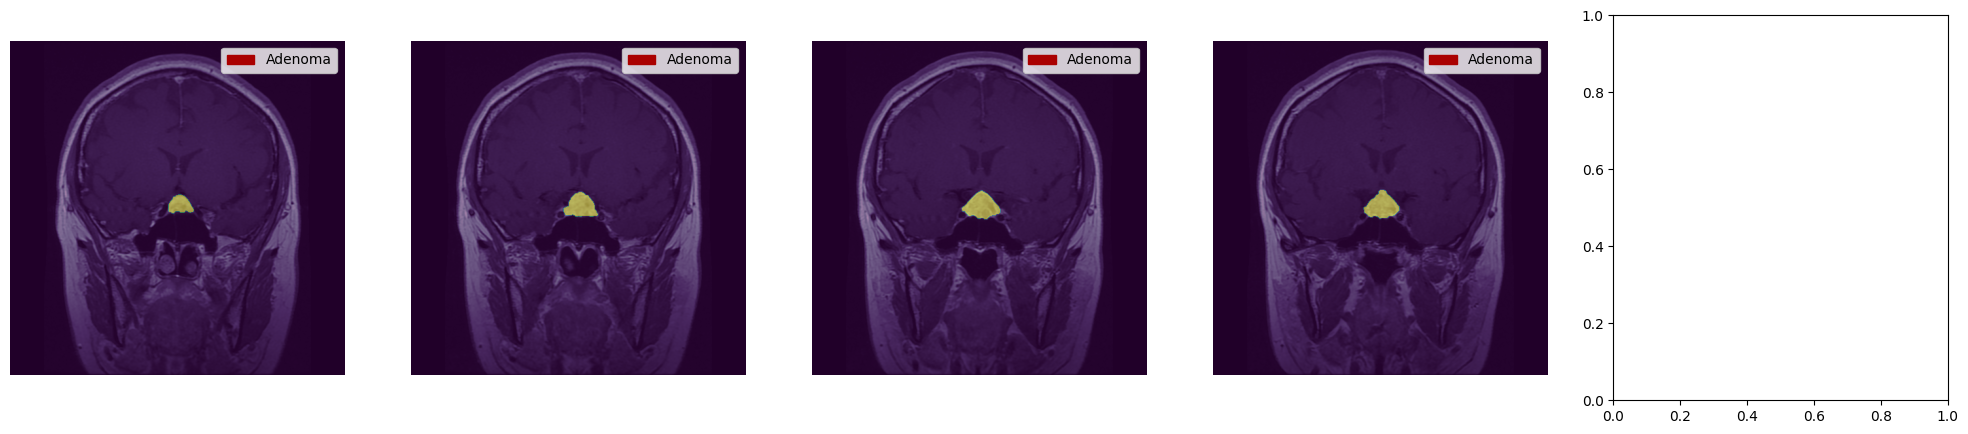

In [96]:
imgs,msks = next(iter(valid_loader_v))

plot_batch(imgs, msks, size=5)

plot_batch(imgs, imgs, size=5)

plot_batch(msks_2, msks_2, size=1)

In [100]:
imgs,msks = next(iter(valid_loader))

plot_batch(imgs, msks, size=5)

plot_batch(imgs, imgs, size=5)

NameError: name 'valid_loader' is not defined

In [137]:
len(train_dataset)

2771

In [138]:
len(valid_dataset)

433

In [ ]:
history_all_sota

In [ ]:
max(history['Valid Jaccard'])

In [61]:
def build_model():

    model = smp.UnetPlusPlus(

        encoder_name='efficientnet-b6' ,

                  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7

        encoder_weights='imagenet',# use `imagenet` pre-trained weights for encoder initialization

        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)

        classes=1   ,     # model output channels (number of classes in your dataset)

        activation=None,

    )

    model.to('cuda')

    return model



def load_model(path):

    model = build_model()

    model.load_state_dict(torch.load(path))

    model.eval()

    return model



for fold in range(1):

    seg_model_name = 'UNetPPEffb6_LAST'

    print(f'#'*15)

    print(f'### Fold: {fold}')

    print(f'#'*15)

    run = wandb.init(project='uw-maddison-gi-tract', 

                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},

                     anonymous=anonymous,

                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",

                     group=CFG.comment,

                    )

    train_loader, valid_loader = train_loader,valid_loader

    model     =   build_model()

    # UNet(1,1).to('cuda')

    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

    scheduler =  fetch_scheduler(optimizer) 

    # fetch_scheduler(optimizer)

    

    model, historys_UNET = run_training(model, optimizer, scheduler,

                                device=CFG.device,

                                num_epochs=CFG.epochs)

    # run.finish()

    # display(ipd.IFrame(run.url, width=1000, height=720))

    plt.figure(figsize=(12,9))



    plt.plot(historys_UNET['Train Loss'], label=f'Training Loss')

    plt.plot(historys_UNET['Valid Loss'], label=f'Validation Loss')

    plt.xlabel('Epoch')

    plt.ylabel('Loss')

    plt.legend()

    plt.title(f'Loss History-model{seg_model_name}')





    plt.figure(figsize=(17,9))

    plt.subplot(1, 2, 1)

    plt.plot(historys_UNET['Train Dice'], label=f'Training Dice')

    plt.plot(historys_UNET['Valid Dice'], label=f'Validation Dice')

    plt.xlabel('Epoch')

    plt.ylabel('Dice')

    plt.legend()

    plt.title(f'Dice History-model{seg_model_name}')



    plt.subplot(1, 2, 2)

    plt.plot(historys_UNET['Train Jaccard'], label=f'Training Jaccard')

    plt.plot(historys_UNET['Valid Jaccard'], label=f'Validation Jaccard')

    plt.xlabel('Epoch')

    plt.ylabel('Jaccard')

    plt.legend()

    plt.title(f'Jaccard History-model{seg_model_name}')

    plt.show()

    torch.save(model.state_dict(), f'{seg_model_name}_std.pth')

    torch.save(model, f'{seg_model_name}.pt')

###############
### Fold: 0
###############


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth
100%|██████████| 165M/165M [00:06<00:00, 25.3MB/s] 


cuda: Tesla T4

Epoch 1/200

Train : 100%|██████████| 88/88 [04:50<00:00,  3.30s/it, gpu_mem=13.70 GB, lr=0.00010, train_loss=1.0427]


Train Dice: 0.2052 | Train Jaccard: 0.4370


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.84s/it, gpu_memory=6.00 GB, lr=0.00010, valid_loss=1.1437]


Valid Dice: 0.1200 | Valid Jaccard: 0.0832
Valid Score Improved (-inf ---> 0.1200)
Model Saved


Epoch 2/200

Train : 100%|██████████| 88/88 [04:39<00:00,  3.18s/it, gpu_mem=13.82 GB, lr=0.00010, train_loss=0.2577]


Train Dice: 0.2874 | Train Jaccard: 0.4825


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.84s/it, gpu_memory=6.06 GB, lr=0.00010, valid_loss=1.1716]


Valid Dice: 0.0936 | Valid Jaccard: 0.0596


Epoch 3/200

Train : 100%|██████████| 88/88 [04:44<00:00,  3.23s/it, gpu_mem=13.79 GB, lr=0.00010, train_loss=-0.1228]


Train Dice: 0.3849 | Train Jaccard: 0.5102


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.84s/it, gpu_memory=6.11 GB, lr=0.00010, valid_loss=1.3743]


Valid Dice: 0.1898 | Valid Jaccard: 0.1162
Valid Score Improved (0.1200 ---> 0.1898)
Model Saved


Epoch 4/200

Train : 100%|██████████| 88/88 [04:35<00:00,  3.13s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-0.6011]


Train Dice: 0.4547 | Train Jaccard: 0.6781


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.81s/it, gpu_memory=6.08 GB, lr=0.00010, valid_loss=1.1945]


Valid Dice: 0.0742 | Valid Jaccard: 0.0505


Epoch 5/200

Train : 100%|██████████| 88/88 [04:40<00:00,  3.18s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-0.8257]


Train Dice: 0.4647 | Train Jaccard: 0.6956


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.84s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=1.2181]


Valid Dice: 0.2991 | Valid Jaccard: 0.2164
Valid Score Improved (0.1898 ---> 0.2991)
Model Saved


Epoch 6/200

Train : 100%|██████████| 88/88 [04:47<00:00,  3.27s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-1.1954]


Train Dice: 0.4917 | Train Jaccard: 0.6264


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.80s/it, gpu_memory=6.11 GB, lr=0.00010, valid_loss=1.3332]


Valid Dice: 0.3099 | Valid Jaccard: 0.2222
Valid Score Improved (0.2991 ---> 0.3099)
Model Saved


Epoch 7/200

Train : 100%|██████████| 88/88 [04:42<00:00,  3.20s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-1.3187]


Train Dice: 0.4216 | Train Jaccard: 0.6102


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.22 GB, lr=0.00010, valid_loss=0.9877]


Valid Dice: 0.3392 | Valid Jaccard: 0.2461
Valid Score Improved (0.3099 ---> 0.3392)
Model Saved


Epoch 8/200

Train : 100%|██████████| 88/88 [04:53<00:00,  3.34s/it, gpu_mem=13.82 GB, lr=0.00010, train_loss=-2.0888]


Train Dice: 0.4707 | Train Jaccard: 0.7415


Valid : 100%|██████████| 13/13 [00:24<00:00,  1.85s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=0.9196]


Valid Dice: 0.2847 | Valid Jaccard: 0.2065


Epoch 9/200

Train : 100%|██████████| 88/88 [04:33<00:00,  3.11s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-2.2847]


Train Dice: 0.5029 | Train Jaccard: 0.8053


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.21 GB, lr=0.00010, valid_loss=0.7348]


Valid Dice: 0.5269 | Valid Jaccard: 0.4132
Valid Score Improved (0.3392 ---> 0.5269)
Model Saved


Epoch 10/200

Train : 100%|██████████| 88/88 [04:40<00:00,  3.19s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-3.1162]


Train Dice: 0.4987 | Train Jaccard: 0.8780


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.83s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=0.6707]


Valid Dice: 0.5306 | Valid Jaccard: 0.4112
Valid Score Improved (0.5269 ---> 0.5306)
Model Saved


Epoch 11/200

Train : 100%|██████████| 88/88 [04:33<00:00,  3.10s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-3.2657]


Train Dice: 0.5178 | Train Jaccard: 0.8797


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.81s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=0.6091]


Valid Dice: 0.5111 | Valid Jaccard: 0.4055


Epoch 12/200

Train : 100%|██████████| 88/88 [04:45<00:00,  3.25s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-2.9920]


Train Dice: 0.4976 | Train Jaccard: 0.7323


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=2.0546]


Valid Dice: 0.0626 | Valid Jaccard: 0.0465


Epoch 13/200

Train : 100%|██████████| 88/88 [04:45<00:00,  3.24s/it, gpu_mem=13.81 GB, lr=0.00010, train_loss=-3.5102]


Train Dice: 0.4086 | Train Jaccard: 0.7838


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.81s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=0.6719]


Valid Dice: 0.4037 | Valid Jaccard: 0.3149


Epoch 14/200

Train : 100%|██████████| 88/88 [04:39<00:00,  3.17s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-4.1068]


Train Dice: 0.5075 | Train Jaccard: 0.9336


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.80s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=0.6958]


Valid Dice: 0.3132 | Valid Jaccard: 0.2362


Epoch 15/200

Train : 100%|██████████| 88/88 [04:31<00:00,  3.08s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-4.2708]


Train Dice: 0.5193 | Train Jaccard: 0.9669


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=0.6827]


Valid Dice: 0.2961 | Valid Jaccard: 0.2275


Epoch 16/200

Train : 100%|██████████| 88/88 [04:36<00:00,  3.15s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-4.3035]


Train Dice: 0.5206 | Train Jaccard: 0.8248


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.84s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=0.5302]


Valid Dice: 0.4595 | Valid Jaccard: 0.3668


Epoch 17/200

Train : 100%|██████████| 88/88 [04:41<00:00,  3.20s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-4.7906]


Train Dice: 0.5308 | Train Jaccard: 1.0280


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=0.4941]


Valid Dice: 0.5025 | Valid Jaccard: 0.3992


Epoch 18/200

Train : 100%|██████████| 88/88 [04:34<00:00,  3.12s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-5.2663]


Train Dice: 0.5423 | Train Jaccard: 1.0697


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=0.6159]


Valid Dice: 0.3540 | Valid Jaccard: 0.2754


Epoch 19/200

Train : 100%|██████████| 88/88 [04:40<00:00,  3.18s/it, gpu_mem=13.84 GB, lr=0.00010, train_loss=-5.0401]


Train Dice: 0.5512 | Train Jaccard: 0.9353


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.23 GB, lr=0.00010, valid_loss=0.5046]


Valid Dice: 0.4959 | Valid Jaccard: 0.3982


Epoch 20/200

Train : 100%|██████████| 88/88 [04:33<00:00,  3.11s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-5.4491]


Train Dice: 0.5577 | Train Jaccard: 1.0248


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.5680]


Valid Dice: 0.4073 | Valid Jaccard: 0.3188


Epoch 21/200

Train : 100%|██████████| 88/88 [04:44<00:00,  3.23s/it, gpu_mem=13.84 GB, lr=0.00010, train_loss=-6.0993]


Train Dice: 0.5448 | Train Jaccard: 1.0634


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.8826]


Valid Dice: 0.1444 | Valid Jaccard: 0.1013


Epoch 22/200

Train : 100%|██████████| 88/88 [04:41<00:00,  3.20s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-6.0728]


Train Dice: 0.5373 | Train Jaccard: 1.0428


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.9010]


Valid Dice: 0.3065 | Valid Jaccard: 0.2358


Epoch 23/200

Train : 100%|██████████| 88/88 [04:36<00:00,  3.14s/it, gpu_mem=13.81 GB, lr=0.00010, train_loss=-5.6738] 


Train Dice: 0.5773 | Train Jaccard: 1.0186


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.83s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.6536]


Valid Dice: 0.3276 | Valid Jaccard: 0.2517


Epoch 24/200

Train : 100%|██████████| 88/88 [04:43<00:00,  3.22s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-6.7335]


Train Dice: 0.5697 | Train Jaccard: 1.0755


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.80s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.6418]


Valid Dice: 0.3273 | Valid Jaccard: 0.2517


Epoch 25/200

Train : 100%|██████████| 88/88 [04:37<00:00,  3.16s/it, gpu_mem=13.84 GB, lr=0.00010, train_loss=-7.0325] 


Train Dice: 0.5660 | Train Jaccard: 1.1231


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.83s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.4789]


Valid Dice: 0.4985 | Valid Jaccard: 0.3955


Epoch 26/200

Train : 100%|██████████| 88/88 [04:43<00:00,  3.22s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-6.8445] 


Train Dice: 0.5739 | Train Jaccard: 1.0539


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.81s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.6135]


Valid Dice: 0.4109 | Valid Jaccard: 0.3198


Epoch 27/200

Train : 100%|██████████| 88/88 [04:43<00:00,  3.22s/it, gpu_mem=13.84 GB, lr=0.00010, train_loss=-7.0777] 


Train Dice: 0.5765 | Train Jaccard: 1.1104


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.83s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.6150]


Valid Dice: 0.3806 | Valid Jaccard: 0.2941


Epoch 28/200

Train : 100%|██████████| 88/88 [04:38<00:00,  3.16s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-7.3338] 


Train Dice: 0.5887 | Train Jaccard: 1.1088


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.83s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.6120]


Valid Dice: 0.5125 | Valid Jaccard: 0.4038


Epoch 29/200

Train : 100%|██████████| 88/88 [04:40<00:00,  3.19s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-7.5774]


Train Dice: 0.5989 | Train Jaccard: 1.1077


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.83s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.5743]


Valid Dice: 0.4093 | Valid Jaccard: 0.3187


Epoch 30/200

Train : 100%|██████████| 88/88 [04:41<00:00,  3.20s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-7.2922]


Train Dice: 0.6090 | Train Jaccard: 1.0652


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.83s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.5235]


Valid Dice: 0.4049 | Valid Jaccard: 0.3220


Epoch 31/200

Train : 100%|██████████| 88/88 [04:32<00:00,  3.09s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-7.3055] 


Train Dice: 0.5993 | Train Jaccard: 0.9283


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.6086]


Valid Dice: 0.4646 | Valid Jaccard: 0.3683


Epoch 32/200

Train : 100%|██████████| 88/88 [04:41<00:00,  3.20s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-7.6613] 


Train Dice: 0.6104 | Train Jaccard: 0.9871


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.81s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.5771]


Valid Dice: 0.5130 | Valid Jaccard: 0.4023


Epoch 33/200

Train : 100%|██████████| 88/88 [04:40<00:00,  3.19s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-6.5025]


Train Dice: 0.6414 | Train Jaccard: 0.9620


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.80s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.4529]


Valid Dice: 0.4768 | Valid Jaccard: 0.3865


Epoch 34/200

Train : 100%|██████████| 88/88 [04:40<00:00,  3.19s/it, gpu_mem=13.82 GB, lr=0.00010, train_loss=-7.6740] 


Train Dice: 0.6261 | Train Jaccard: 0.9822


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.5205]


Valid Dice: 0.4717 | Valid Jaccard: 0.3688


Epoch 35/200

Train : 100%|██████████| 88/88 [04:42<00:00,  3.21s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-7.9354] 


Train Dice: 0.6306 | Train Jaccard: 1.0249


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.81s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.8348]


Valid Dice: 0.3963 | Valid Jaccard: 0.3087


Epoch 36/200

Train : 100%|██████████| 88/88 [04:42<00:00,  3.21s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-8.7115]


Train Dice: 0.6359 | Train Jaccard: 1.0598


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.81s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.5791]


Valid Dice: 0.4047 | Valid Jaccard: 0.3133


Epoch 37/200

Train : 100%|██████████| 88/88 [04:44<00:00,  3.23s/it, gpu_mem=13.81 GB, lr=0.00010, train_loss=-7.6315] 


Train Dice: 0.6533 | Train Jaccard: 1.0892


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.83s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.6721]


Valid Dice: 0.5102 | Valid Jaccard: 0.4024


Epoch 38/200

Train : 100%|██████████| 88/88 [04:46<00:00,  3.26s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-7.3655] 


Train Dice: 0.6403 | Train Jaccard: 0.9145


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.81s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.5083]


Valid Dice: 0.4479 | Valid Jaccard: 0.3548


Epoch 39/200

Train : 100%|██████████| 88/88 [04:38<00:00,  3.17s/it, gpu_mem=13.81 GB, lr=0.00010, train_loss=-8.2707] 


Train Dice: 0.6506 | Train Jaccard: 0.9885


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.80s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.4733]


Valid Dice: 0.4611 | Valid Jaccard: 0.3670


Epoch 40/200

Train : 100%|██████████| 88/88 [04:36<00:00,  3.14s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-8.4666] 


Train Dice: 0.6352 | Train Jaccard: 1.0752


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.84s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.4517]


Valid Dice: 0.5259 | Valid Jaccard: 0.4218


Epoch 41/200

Train : 100%|██████████| 88/88 [04:42<00:00,  3.21s/it, gpu_mem=13.81 GB, lr=0.00010, train_loss=-9.3783]


Train Dice: 0.6680 | Train Jaccard: 1.1273


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.5025]


Valid Dice: 0.4814 | Valid Jaccard: 0.3825


Epoch 42/200

Train : 100%|██████████| 88/88 [04:32<00:00,  3.09s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-9.9955] 


Train Dice: 0.6737 | Train Jaccard: 1.2395


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.81s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.4214]


Valid Dice: 0.5252 | Valid Jaccard: 0.4239


Epoch 43/200

Train : 100%|██████████| 88/88 [04:35<00:00,  3.13s/it, gpu_mem=13.81 GB, lr=0.00010, train_loss=-10.2815]


Train Dice: 0.6743 | Train Jaccard: 1.2211


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.4077]


Valid Dice: 0.5442 | Valid Jaccard: 0.4382
Valid Score Improved (0.5306 ---> 0.5442)
Model Saved


Epoch 44/200

Train : 100%|██████████| 88/88 [04:45<00:00,  3.24s/it, gpu_mem=13.80 GB, lr=0.00010, train_loss=-9.8249] 


Train Dice: 0.6657 | Train Jaccard: 1.2039


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.81s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.5693]


Valid Dice: 0.4831 | Valid Jaccard: 0.3791


Epoch 45/200

Train : 100%|██████████| 88/88 [04:40<00:00,  3.18s/it, gpu_mem=13.83 GB, lr=0.00010, train_loss=-10.2695]


Train Dice: 0.6317 | Train Jaccard: 1.2108


Valid : 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, gpu_memory=6.25 GB, lr=0.00010, valid_loss=0.5075]


Valid Dice: 0.4764 | Valid Jaccard: 0.3741


Epoch 46/200

Train : 100%|██████████| 88/88 [04:34<00:00,  3.12s/it, gpu_mem=13.81 GB, lr=0.00010, train_loss=-10.6067]


Train Dice: 0.6263 | Train Jaccard: 1.1404


Valid :   0%|          | 0/13 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
history

In [ ]:
    torch.save(model, 'UNetPPEffb6_600_2.pt')


In [38]:
plt.figure(figsize=(12,9))



plt.plot(historys_UNET['Train Loss'], label=f'Training Loss')

plt.plot(historys_UNET['Valid Loss'], label=f'Validation Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.title(f'Loss History-model{seg_model_name}')





plt.figure(figsize=(17,9))

plt.subplot(1, 2, 1)

plt.plot(historys_UNET['Train Dice'], label=f'Training Dice')

plt.plot(historys_UNET['Valid Dice'], label=f'Validation Dice')

plt.xlabel('Epoch')

plt.ylabel('Dice')

plt.legend()

plt.title(f'Dice History-model{seg_model_name}')



plt.subplot(1, 2, 2)

plt.plot(historys_UNET['Train Jaccard'], label=f'Training Jaccard')

plt.plot(historys_UNET['Valid Jaccard'], label=f'Validation Jaccard')

plt.xlabel('Epoch')

plt.ylabel('Jaccard')

plt.legend()

plt.title(f'Jaccard History-model{seg_model_name}')

plt.show()

NameError: name 'historys_UNET' is not defined

<Figure size 1200x900 with 0 Axes>

In [104]:
def build_model():

    model = smp.FPN(

        encoder_name='efficientnet-b6' ,

                  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7

        encoder_weights='imagenet',# use `imagenet` pre-trained weights for encoder initialization

        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)

        classes=1   ,     # model output channels (number of classes in your dataset)

        activation=None,

    )

    model.to('cuda')

    return model



def load_model(path):

    model = build_model()

    model.load_state_dict(torch.load(path))

    model.eval()

    return model



for fold in range(1):

    seg_model_name = 'UNetPPEffb6_600_3'

    print(f'#'*15)

    print(f'### Fold: {fold}')

    print(f'#'*15)

    run = wandb.init(project='uw-maddison-gi-tract', 

                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},

                     anonymous=anonymous,

                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",

                     group=CFG.comment,

                    )

    



    data_transforms = {

        "train": A.Compose([

            A.augmentations.crops.transforms.CenterCrop(224,224),

            A.Resize(224,224, interpolation=cv2.INTER_NEAREST),

            A.CoarseDropout(max_holes=8, max_height=224//20, max_width=224//20,

                            min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),

            



            A.HorizontalFlip(p=0.5),

    #         A.VerticalFlip(p=0.5),

            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),

            A.OneOf([

                A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),

                # A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),

                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=None, p=1.0)

            ], p=0.25),

            # A.ColorJitter(brightness=0, contrast=0.0002, saturation=0, hue=0.2, always_apply=False, p=0.5),

            # A.CoarseDropout(max_holes=8, max_height=224//20, max_width=224//20,

            #                  min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),

            A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),

            ], p=1.0),

        

        "valid": A.Compose([

            A.augmentations.crops.transforms.CenterCrop(224,224),

            A.Resize(224,224, interpolation=cv2.INTER_NEAREST),

            A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),

            ], p=1.0)

    }

    train_dataset = BuildDataset(np.concatenate((dataset_X, x_train), axis=0),np.concatenate((dataset_y, y_train), axis=0), transforms=data_transforms['train'])

    valid_dataset = BuildDataset(x_val,y_val, transforms=data_transforms['valid'])



    train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)

    valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

    train_loader, valid_loader = train_loader,valid_loader

    model     =   build_model()

    # UNet(1,1).to('cuda')

    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

    scheduler =  fetch_scheduler(optimizer) 

    # fetch_scheduler(optimizer)

    

    model, historys = run_training(model, optimizer, scheduler,

                                device=CFG.device,

                                num_epochs=CFG.epochs)

    # run.finish()

    # display(ipd.IFrame(run.url, width=1000, height=720))

    plt.figure(figsize=(12,9))



    plt.plot(historys['Train Loss'], label=f'Training Loss')

    plt.plot(historys['Valid Loss'], label=f'Validation Loss')

    plt.xlabel('Epoch')

    plt.ylabel('Loss')

    plt.legend()

    plt.title(f'Loss History-model{seg_model_name}')





    plt.figure(figsize=(17,9))

    plt.subplot(1, 2, 1)

    plt.plot(historys['Train Dice'], label=f'Training Dice')

    plt.plot(historys['Valid Dice'], label=f'Validation Dice')

    plt.xlabel('Epoch')

    plt.ylabel('Dice')

    plt.legend()

    plt.title(f'Dice History-model{seg_model_name}')



    plt.subplot(1, 2, 2)

    plt.plot(historys['Train Jaccard'], label=f'Training Jaccard')

    plt.plot(historys['Valid Jaccard'], label=f'Validation Jaccard')

    plt.xlabel('Epoch')

    plt.ylabel('Jaccard')

    plt.legend()

    plt.title(f'Jaccard History-model{seg_model_name}')

    plt.show()

    torch.save(model.state_dict(), f'{seg_model_name}_std.pth')

    torch.save(model, f'{seg_model_name}.pt')

###############
### Fold: 0
###############


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:


    history_all_sota[f'{seg_model_name}'].append(history)

    gpus = GPUtil.getGPUs()

    gpu = gpus[0]

    GPUtil.showUtilization()

    free_memory = gpu.memoryFree

    torch.cuda.empty_cache()

In [ ]:
torch.save(model, 'UNetPPEffb1_300_bs64.pt')

In [ ]:
torch.save(model.state_dict(), 'UNetPPEffb1_300_bs64_state_dict')

In [ ]:
run = wandb.init(project='uw-maddison-gi-tract', 

                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},

                     anonymous=anonymous,

                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",

                     group=CFG.comment,

                    )

In [ ]:
print(f""" MODEL: {seg_model_name} Train DICE MAX:{max(history[0]['Train Dice'])} IOU MAX:{max(history[0]['Train Jaccard'])} Train Loss MIN:{min(history[0]['Train Loss'])} 

        MODEL: {seg_model_name} VAL DICE MAX:{max(history[0]['Valid Dice'])} VAL IOU MAX:{max(history[0]['Valid Jaccard'])} VAL Loss MIN:{min(history[0]['Valid Loss'])} \n """)

## Валидация

In [ ]:
import GPUtil

import torch



gpus = GPUtil.getGPUs()



gpu = gpus[0]



GPUtil.showUtilization()



free_memory = gpu.memoryFree



torch.cuda.empty_cache()


In [ ]:
import matplotlib.pyplot as plt



# Dictionary

my_dict = {'name1': 10, 'name2': 20, 'name3': 10}



# Extract values

values = list(my_dict.values())



# Create histogram plot

plt.hist(x=df['IOU'])



# Add labels and title

plt.xlabel('Values')

plt.ylabel('Frequency')

plt.title('Histogram')



# Show the plot

plt.show()

In [ ]:
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [ ]:
weight_c1 = 'UNetPPEffb6_600_std.pth'

model = smp.UnetPlusPlus(

    encoder_name="efficientnet-b6", encoder_weights=None, in_channels=1, classes=1)

# weight_c1 = path2 / 'deeplabv3plus.pkl'

# self._model = smp.DeepLabV3Plus(

#     encoder_name="efficientnet-b6", encoder_weights=None, in_channels=1, classes=1)

model.to('cuda')

model.load_state_dict(torch.load(

    weight_c1, map_location='cuda'))

model.eval()


In [ ]:
target_shape

In [ ]:
valid_dataset = BuildDataset_prod(x_val, transforms=transforms_prod['prod'])

In [ ]:


imgs= next(iter(valid_dataset))

# imgs = imgs.to('cuda')

val_scores=[]

preds = []

print(sum(imgs))

# imgs = imgs[None, :,:,:]

# mask = mask[None, :,:,:]

for ings in valid_loader:

    for fold in range(1):

        # model = load_model(f"best_epoch-{fold:02d}.bin")

        with torch.no_grad():

            pred = model(imgs).cpu()

            pred = (nn.Sigmoid()(pred)>0.5).double()

            

            # preds = torch.argmax(nn.Sigmoid()(pred),axis=1).double()

            # val_dice = dice_coef(mask, pred).cpu().detach().numpy()

            # val_jaccard = iou_coef(mask, pred).cpu().detach().numpy()

            # val_scores.append([val_dice, val_jaccard])

            

            

            print( sum(sum(sum(sum(pred)))))

        preds.append(pred)

        

    imgs  = imgs.cpu().detach()

    preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()




In [ ]:
device='cpu'

In [ ]:
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [ ]:
preds = []

for step, (images, masks) in enumerate(valid_loader):        

        images  = images.to(device, dtype=torch.float).cpu()

        masks   = masks.to(device, dtype=torch.float).cpu()

        models=model.cpu()



        for fold in range(1):

            # model = load_model(f"best_epoch-{fold:02d}.bin")

            with torch.no_grad():

                pred = models(images).cpu()

                pred = (nn.Sigmoid()(pred)>0.5).double()

                

                # preds = torch.argmax(nn.Sigmoid()(pred),axis=1).double()

                # val_dice = dice_coef(mask, pred).cpu().detach().numpy()

                # val_jaccard = iou_coef(mask, pred).cpu().detach().numpy()

                # val_scores.append([val_dice, val_jaccard])

                

                

                print( sum(sum(sum(sum(pred)))))

            preds.append(pred)

            

        images  = images.cpu().detach()

        preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

        break


In [ ]:
plot_batch(pred, mask, size=1)

In [ ]:
def dice_coef_2(y_true, y_pred):

    y_true_f = y_true.flatten()

    y_pred_f = y_pred.flatten()

    smooth = 0.0001

    intersection = (y_true*y_pred).sum()

    print(intersection)

    print(((y_true_f).sum() + (y_pred_f).sum() + smooth))

    print((y_true_f).sum())

    print((y_pred_f).sum())

    return (2. * intersection + smooth) / ((y_true_f).sum() + (y_pred_f).sum() + smooth)

In [ ]:


def dice_coef(y_true, y_pred, thr=0.3, dim=(2,3), epsilon=0.001):

    y_true = y_true.to(torch.float32)

    y_pred = (y_pred>thr).to(torch.float32)

    inter = (y_true*y_pred).sum(dim=dim)

    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)

    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))

    return dice

In [ ]:
dice_coef(masks, preds).cpu().detach().numpy()

In [ ]:
iou_coef(masks, preds).cpu().detach().numpy()

In [ ]:
print(val_scores)

In [ ]:
torch.save(model.s, 'UNetPPEffb6_600_2.pt')

In [ ]:
torch.save(model.state_dict(), 'UNetPPEffb6_600_std.pth')

In [ ]:
sum(sum(sum(mask[:1])))

In [ ]:
plot_batch(images, images, size=5)

plot_batch(images, masks, size=5)

plot_batch(images, preds, size=5)
